In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<i>The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</i>''')

# Greenhouse gases and radiative forcing
You probably read that methane is a greenhouse gas more potent than CO<sub>2</sub>. Among many other things, it is often singled out as the main climate issue linked with [eating meat and dairy](https://www.theguardian.com/environment/2018/dec/21/lifestyle-change-eat-less-meat-climate-change), or with [fugitive emissions from natural gas extraction](https://www.nytimes.com/2018/06/21/climate/methane-leaks.html).

Obviously, we need to take CH<sub>4</sub> (methane's little name) into account when we calculate carbon footprints, and when we compare alternatives. To use our two previous examples, we need to measure methane emissions to compare eating a hamburger vs. brunching on avocado flown from Mexico, or to calculate the extra warming due to emitting methane when we dig for natural gas (then burned to run a turbine so that you can have electricity at home). The issue is that methane decays faster than carbon dioxide (when CO<sub>2</sub> decays at all, which is, well, our main problem with CO<sub>2</sub> emissions). We use something called "global warming potential" to express the potency of a greenhouse gas to trap heat. This factor is obtained after integrating (i.e. summing up) the amount of heat that a given amount of each greenhouse gas traps over a certain amount of time. The quantity we integrate is called "radiative forcing", it is basically how good a blanket a gas is.

Methane and carbon dioxide are not the only members of the greenhouse gas club. The Intergovernmental Panel on Climate Change (IPCC) has made a list of over 200 greenhouse gases, the most notable of which (apart from the abovementioned couple) are dinitrogen oxide (or _nitrous oxide_, N<sub>2</sub>O), chlorofluorocarbons (CFCs, including the famous [_Freon_](https://en.wikipedia.org/wiki/Freon) family), and hydrofluorocarbons (HFCs, modern substitutes for CFCs).


This is a model of greenhouse gases' radiative forcing, using the values of the IPCC AR5, pages 731-738.

    https://www.ipcc.ch/site/assets/uploads/2018/02/WG1AR5_Chapter08_FINAL.pdf

CO2 follows a more intricate cycle, and cannot be modelled with a simple decay
function. The model used can be found in Joos et al. (2013).
    
    https://www.atmos-chem-phys.net/13/2793/2013/acp-13-2793-2013.pdf

What follows is inspired by the PhD thesis of Allan Shimako, available here
    
    https://tel.archives-ouvertes.fr/tel-01706684/document

Radiative forcing is the ability of certain gases to "trap" heat in the atmosphere,
this phenomenon is better known as greenhouse effect. Some gases are more efficient
than others at trapping heat, and some remain much longer than others.

The output of this code is an animation with three panels, showing the effect of
the instant release of 1 Mt (1 megatonne = 1 million tonnes = 1 billion kilograms)
of each of the greenhouse gases selected, where:
- the top panel shows the instant forcing due to the gases being present in
    the Earth's atmosphere (in watts per square meter),
- the middle panel shows the cumulative effect of that forcing, equal to
    the areas under the curves in the top graph integrated over the Earth's
    surface every year (in joules),
- the bottom panel shows the cumulated forcing (middle panel values) of
    gases relative to that of carbon dioxide. This measure is called "global
    warming potential" and is usually calculated for three time horizons: 20,
    100, and 500 years, which are shown on the bottom graph.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import trange
from matplotlib import animation

When decaying or being removed from the atmosphere, most gases follow an exponential decay after a pulse emission (an instantaneous emission of a given quantity). We modelled this decay as a linear combination:

$$
IRF_x = a_{x,0} + \sum a_{x,i} e^\frac{-t}{τ_x,i} \textrm{ for } t \geq 0
$$

with 

$$
\sum a_{x,i} = 1
$$

For most substances, $a_{x,0} = 0$, i.e. they disappear completely from the atmosphere given enough time. Moreover, the only non-zero coefficient is commonly $a_{x,1} = 1$ (except for CO<sub>2</sub>), which yields:

$$
IRF_x = \sum e^\frac{-t}{τ_x}
$$

The variable $τ_x$ is the lifetime of the substance.

The table a_x_i contains the IPCC table, with $τ_x$ and radiative forcing properties, as well as molar weights (masses?) which we will need to convert ppb into kg. All the information we need to calculate the global warming potential factors should be here now.

In [2]:
a_x_i = pd.read_csv('GHG_property_table.csv',index_col=0).drop('Carbon dioxide')
a_x_i['Lifetime (Years)'] = pd.to_numeric(a_x_i['Lifetime (Years)'])
a_x_i.head()

,Chemical Formula,Lifetime (Years),Radiative Efficiency (W m-2 ppb-1),AGWP 20-year (W m-2 yr kg-1),GWP 20-year,AGWP 100-year (W m-2 yr kg-1),GWP 100-year,AGTP 20-year (K kg-1),GTP 20-year,AGTP 50-year (K kg-1),GTP 50-year,AGTP 100-year (K kg-1),GTP 100-year,Molar mass (g mol-1),Correction
"Acronym, Common Name or Chemical Name",,,,,,,,,,,,,,,
"(E)-1-Chloro-3,3,3-trifluoroprop-1-ene",trans-CF3CH=CHCl,0.07,0.04,1.370000e-13,5,1.370000e-13,1,1.090000e-15,2,1.540000e-16,<1,1.120000e-16,<1,130.49,1.0
(E)-HFC-1225ye,CF3CF=CHF(E),0.01,0.01,7.250000e-15,<1,7.250000e-15,<1,5.770000e-17,<1,8.140000e-18,<1,5.950000e-18,<1,132.03,1.0
(E)-HFC-1234ze,trans-CF3CH=CHF,0.04,0.04,8.740000e-14,4,8.740000e-14,<1,6.980000e-16,<1,9.820000e-17,<1,7.180000e-17,<1,114.04,1.0
(Trifluoromethyl) sulphur pentafluoride,SF5CF3,800.00,0.59,3.360000e-10,13500,1.600000e-09,17400,9.930000e-12,14500,1.100000e-11,17800,1.110000e-11,20200,196.06,1.0
(Z)-HFC-1225ye,CF3CF=CHF(Z),0.02,0.02,2.140000e-14,<1,2.140000e-14,<1,1.700000e-16,<1,2.400000e-17,<1,1.760000e-17,<1,132.03,1.0


We import carbon dioxide information separately, because its decay profile is a little different (more complex). As explained, the radiative forcing of CO<sub>2</sub> in the atmosphere is modelled as the sum of a constant (i.e. a fraction of the emitted CO<sub>2</sub> remains forever, $\tau_0 = \infty$) and three exponential decay functions:

In [3]:
a_CO2_i = pd.read_csv('CO2_property_table.csv',index_col=0)
a_CO2_i

,rel. error,a0,a1,a2,a3,т1,т2,т3,Radiative Efficiency (W m-2 ppb-1),Molar mass (g mol-1),Correction
Substance,,,,,,,,,,,
Carbon dioxide,0.6,0.2173,0.224,0.2824,0.2763,394.4,36.54,4.304,0.000014,44.01,1


These various factors all correspond to a biophysical process. Factor $a_0$ correspond to the geological reabsorption (hence why we consider $τ_0$ infinite at our scale), $a_1$ corresponds to deep ocean equilibration (a long-term mechanism, $τ_1$ is about 400 years), while $a_2$ and $a_3$ model faster absorption phenomena, respectively base ($τ_2\approx35$ years) and rapid ($τ_3\approx4$ years) biospheric and ocean uptake.

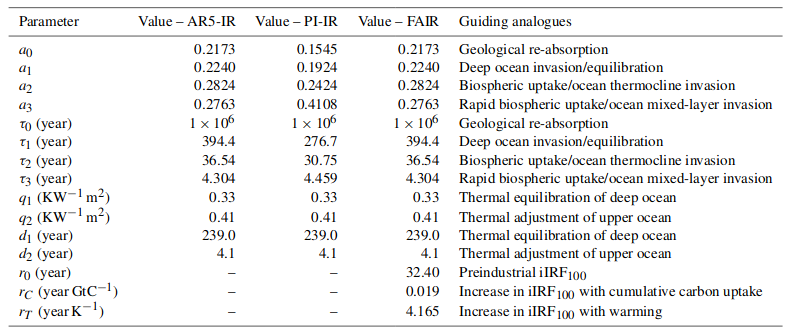
Table 1 from Millar et al. (2017) _A modified impulse-response representation of the globalnear-surface air temperature and atmospheric concentrationresponse to carbon dioxide emissions_.

As Joos et al. (2013) explain,
> "CO<sub>2</sub> is, unlike most other agents, not destroyed by chemical  reactions  in  the  atmosphere  or  deposited  on  the  earth surface,  but  redistributed  within  the  major  carbon  reservoirs: atmosphere, ocean, land biosphere involving multiple timescales for exchange among and for overturning within these reservoirs"

We also need a few natural constants, such as the mass of the atmosphere or the area of Earth. Basic stuff. We will also choose to focus on the three main greenhouse gases.

In [12]:
# Constants
substances = [
       'Nitrous oxide',
       'Methane',
       'Carbon dioxide']

earth_area = 510072000000000 # m2
atm_mass   = 5.1480e18 # kg
atm_mol    = 29.80 # g/mol
year_in_s  = 365.2425 * 24 * 3600 # s/yr
substances

['Nitrous oxide', 'Methane', 'Carbon dioxide']

Now we are ready to calculate the impulse response function (IRF) of the various gases.

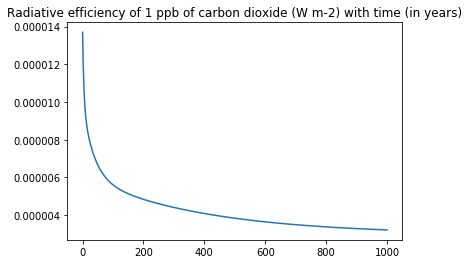

In [48]:
horizon  = 1000 # years
steps    = 10000 # points in time
stepsize = steps/horizon # year
time     = np.linspace(0,horizon,steps+1)

# The impulse response function is always 1 at t = 0,
# and then decreases to model the substance being removed from the atmosphere

# This is what's remaining over time for non-CO2 GHGs
IRF_t = pd.DataFrame(np.exp(np.outer(-time,1/a_x_i['Lifetime (Years)'])),
            index=time,
            columns=a_x_i.index) 

# ...and for CO2
IRF_t['Carbon dioxide'] = a_CO2_i.a0.values + \
                        a_CO2_i.a1.values * np.exp(np.outer(-time,1/a_CO2_i.т1)) + \
                        a_CO2_i.a2.values * np.exp(np.outer(-time,1/a_CO2_i.т2)) + \
                        a_CO2_i.a3.values * np.exp(np.outer(-time,1/a_CO2_i.т3)) # Remaining over time GHGs

# We multiply by the specific radiative efficiency to get the absolute global warming potential
AGWP_ppb = a_x_i['Radiative Efficiency (W m-2 ppb-1)'] * IRF_t
AGWP_ppb['Carbon dioxide'] = a_CO2_i['Radiative Efficiency (W m-2 ppb-1)'].values * IRF_t['Carbon dioxide']
AGWP_ppb['Carbon dioxide'].plot(title='Radiative efficiency of 1 ppb of carbon dioxide (W m-2) with time (in years)')

0.0       2.161543e-13
0.1       2.144182e-13
0.2       2.126959e-13
0.3       2.109875e-13
0.4       2.092929e-13
0.5       2.076118e-13
0.6       2.059443e-13
0.7       2.042901e-13
0.8       2.026492e-13
0.9       2.010215e-13
1.0       1.994069e-13
1.1       1.978052e-13
1.2       1.962165e-13
1.3       1.946404e-13
1.4       1.930771e-13
1.5       1.915263e-13
1.6       1.899879e-13
1.7       1.884619e-13
1.8       1.869482e-13
1.9       1.854466e-13
2.0       1.839570e-13
2.1       1.824795e-13
2.2       1.810138e-13
2.3       1.795599e-13
2.4       1.781176e-13
2.5       1.766870e-13
2.6       1.752678e-13
2.7       1.738601e-13
2.8       1.724636e-13
2.9       1.710784e-13
              ...     
997.1     2.585736e-48
997.2     2.564968e-48
997.3     2.544366e-48
997.4     2.523929e-48
997.5     2.503657e-48
997.6     2.483547e-48
997.7     2.463599e-48
997.8     2.443811e-48
997.9     2.424182e-48
998.0     2.404711e-48
998.1     2.385396e-48
998.2     2.366236e-48
998.3     2

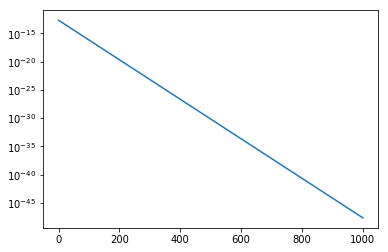

In [45]:
RFI_ppb = IRF_ppb.cumsum(0) / stepsize # Radiative forcing integrated, in ppb

molar_weights = pd.concat([a_x_i['Molar mass (g mol-1)'], a_CO2_i['Molar mass (g mol-1)']])
correction    = pd.concat([a_x_i['Correction'], a_CO2_i['Correction']])

IRF_kg = IRF_ppb/molar_weights * atm_mol/atm_mass * 1e9 * correction
RFI_kg = RFI_ppb/molar_weights * atm_mol/atm_mass * 1e9 * correction
IRF_kg['Methane'].plot(logy=True)
GWP = RFI_kg.div(RFI_kg['Carbon dioxide'],0)    # Global warming potential
#GWP[substances].plot(logy=True)
print(IRF_kg['Methane'])

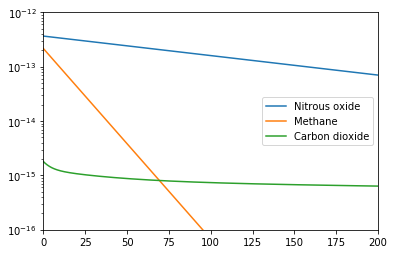

In [16]:
IRF_kg[substances].plot(logy=True, ylim=[1e-16,1e-12], xlim=[0,200])

# Radiative forcing and temperature
As such, radiative forcing does not really tell us how much of a problem greenhouse gas emissions are. As Joos et al. (2013) write it,
> "[T]he AGWP does not directly translate into a well-known climate response."

In other words, we do not really know what to do with this information, we are only halfway through. The good news is that is possible to (approximately) compute the increase in temperature due to a pulse emission.